In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime
import py_vollib_vectorized
import torch 
import torch.nn as nn
import yfinance as yf
from scipy import arange

C:\Users\zkr_l\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


$$(P_1)_{i,j}=\left(\tau_j\frac{c(m_i,\tau_j)-c(m_i,\tau_{j+1})}{\tau_{j+1}-\tau_j}\right)^+, (P_2)_{i,j}=\left(\frac{c(m_{i+1},\tau_j)-c(m_i,\tau_j)}{m_{i+1}-m_i}\right)^+\\(P_3)_{i,j}=\left(\frac{c(m_i,\tau_j)-c(m_{i-1},\tau_j)}{m_i-m_{i-1}}-\frac{c(m_{i+1},\tau_j)-c(m_i,\tau_j)}{m_{i+1}-m_i}\right)^+$$

In [2]:
def penalty_tensor(moneyness, tau):
    """
    Creates matrices used to calculate arbitrage penalties for a set of options.

    Args:
        moneyness (list or array): Array of moneyness values of the options.
        tau (list or array): Array of time to maturity values of the options.

    Returns:
        tuple: A tuple containing three torch tensors:
               - P_1 for penalties related to time to maturity.
               - P_2 for penalties related to moneyness changes.
               - P_3 for penalties related to convexity in moneyness.
    """
    # Time penalty matrix P_1
    P_1 = torch.zeros(size=(len(tau), len(tau)), dtype=torch.float)
    for i in range(0,len(tau) - 1):
        diff_tau = tau[i + 1] - tau[i]
        P_1[i, i] = tau[i] / diff_tau
        P_1[i + 1, i] = -tau[i] / diff_tau

    # Moneyness penalty matrix P_2
    P_2 = torch.zeros(size=(len(moneyness), len(moneyness)), dtype=torch.float)
    for i in range(0,len(moneyness) - 1):
        diff_m = moneyness[i + 1] - moneyness[i]
        P_2[i, i + 1] = 1 / diff_m
        P_2[i, i] = -1 / diff_m

    # Convexity penalty matrix P_3
    P_3 = torch.zeros(size=(len(moneyness), len(moneyness)), dtype=torch.float)
    for i in range(1, len(moneyness) - 1):
        diff_m_next = moneyness[i + 1] - moneyness[i]
        diff_m_prev = moneyness[i] - moneyness[i - 1]
        total_diff_m = moneyness[i + 1] - moneyness[i]

        P_3[i, i - 1] = -diff_m_next / (diff_m_prev * total_diff_m)
        P_3[i, i] = total_diff_m / (diff_m_prev * diff_m_next)
        P_3[i, i + 1] = -diff_m_prev / (diff_m_prev * total_diff_m)

    return P_1, P_2, P_3


def calculate_arbitrage_penalties(call_prices, P_1, P_2, P_3):

    time_penalty = torch.max(torch.tensor(0.0), call_prices @ P_1)
    strike_penalty = torch.max(torch.tensor(0.0), P_2 @ call_prices)
    convexity_penalty = torch.max(torch.tensor(0.0), P_3 @ call_prices)

    # sum in the 2nd and 3rd dimensions
    total_penalty = torch.sum(time_penalty, dim=(1, 2)) + torch.sum(strike_penalty, dim=(1, 2)) + torch.sum(convexity_penalty, dim=(1, 2))


    return time_penalty, strike_penalty, convexity_penalty, total_penalty


In [3]:
def relative_call_price(moneyness, maturity, volatility, risk_free_rate=0):

    norm_dist = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    d1 = (-torch.log(moneyness) + maturity * (risk_free_rate + 0.5 * volatility ** 2)) / (volatility * torch.sqrt(maturity))
    d2 = d1 - volatility * torch.sqrt(maturity)
    prices = norm_dist.cdf(d1) - moneyness * norm_dist.cdf(d2) * torch.exp(-risk_free_rate * maturity)

    # Set a minimum price limit to prevent computational inaccuracies
    prices.clamp_(min=1e-8)

    return prices


In [4]:

def DataProcess(datapath):
    NN = 4  # defiens how many options around atm you use in the refression for implied forwad and implied discount factor, min is 2
    DT_CONST = 24 * 3600 * 1000000000

    df = pd.read_csv(datapath, parse_dates=['date', 'exdate'],
                     usecols=['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
                              'forward_price', 'am_settlement'], engine="pyarrow")

    df["dte"] = (df["exdate"].astype('int64') - df["date"].astype('int64')) // DT_CONST
    df = df[(0 == df.am_settlement) & (df.dte > 0)]
    df.index = df['date']
    df.loc[:, 'strike_price'] = df.loc[:, 'strike_price'] / 1000
    df['mid_price'] = .5 * (df['best_bid'] + df['best_offer'])
    df = df[df['mid_price'] > 0]

    df.rename_axis(None, inplace=True)
    df.reset_index(inplace=True, drop=True)

    df['cp_flag'] = df['cp_flag'].map({'C': 'c', 'P': 'p'}).astype('category')

    df_ws = df.loc[:, ['date', 'exdate', 'strike_price', 'cp_flag', 'mid_price']].pivot(
        index=['date', 'exdate', 'strike_price'], columns='cp_flag')
    calls_p = df_ws.loc[:, ('mid_price', 'c')]
    puts_p = df_ws.loc[:, ('mid_price', 'p')]

    df_ws['m_ind'] = 1. - (calls_p - puts_p < 0)

    instr_group_p = df_ws.groupby(level=[0, 1])

    df_ws['m_ind'] = instr_group_p['m_ind'].transform('cumprod')

    df_ws['ind_full'] = instr_group_p['m_ind'].shift(NN).groupby(level=[0, 1]).bfill() - instr_group_p['m_ind'].shift(
        -NN).groupby(level=[0, 1]).ffill()
    df_ws['Ksum'] = df_ws.index.get_level_values('strike_price') * df_ws['ind_full']
    df_ws['Ksum2'] = df_ws.index.get_level_values('strike_price') * df_ws['Ksum']
    df_ws['Psum'] = (puts_p - calls_p) * df_ws['ind_full']
    df_ws['KPsum'] = df_ws.index.get_level_values('strike_price') * df_ws['Psum']

    df_ws['KsumI'] = instr_group_p['Ksum'].transform('sum')
    df_ws['Ksum2I'] = instr_group_p['Ksum2'].transform('sum')
    df_ws['PsumI'] = instr_group_p['Psum'].transform('sum')
    df_ws['KPsumI'] = instr_group_p['KPsum'].transform('sum')

    denom = (2 * NN) * df_ws['Ksum2I'] - df_ws['KsumI'] * df_ws['KsumI']
    df_ws['impl_df'] = ((2 * NN) * df_ws['KPsumI'] - df_ws['PsumI'] * df_ws['KsumI']) / denom
    df_ws['impl_fw'] = (df_ws['KsumI'] * df_ws['KPsumI'] - df_ws['Ksum2I'] * df_ws['PsumI']) / (
            denom * df_ws['impl_df'].values)

    df_ws['otm'] = (df_ws.index.get_level_values('strike_price') >= df_ws['impl_fw'])
    df_ws['dte'] = (df_ws.index.get_level_values("exdate").astype('int64') - df_ws.index.get_level_values(
        "date").astype('int64')) / (24 * 3600 * 1e9 * 365)
    df_ws.loc[df_ws.dte == 0, 'dte'] = 1e-7  # JUST TO PRODUCE A NUMBER, WILL BE OVWEWRITEN LATER ANYWAY
    df_ws['r'] = -np.log(df_ws['impl_df']) / df_ws['dte']
    df_ws['spot'] = df_ws['impl_fw'] * df_ws['impl_df']

    indc = df_ws.otm
    df_ws.loc[indc, 'mid_vols'] = py_vollib_vectorized.vectorized_implied_volatility(
        df_ws.loc[indc][('mid_price', 'c')].values, df_ws.loc[indc].spot.values,
        df_ws.loc[indc].index.get_level_values('strike_price').values, df_ws.loc[indc].dte.values,
        df_ws.loc[indc].r.values,
        'c', q=0,
        model='black_scholes_merton', return_as='numpy',
        on_error='ignore')
    indc = ~df_ws.otm
    df_ws.loc[indc, 'mid_vols'] = py_vollib_vectorized.vectorized_implied_volatility(
        df_ws.loc[indc][('mid_price', 'p')].values, df_ws.loc[indc].spot.values,
        df_ws.loc[indc].index.get_level_values('strike_price').values, df_ws.loc[indc].dte.values,
        df_ws.loc[indc].r.values,
        'p', q=0,
        model='black_scholes_merton', return_as='numpy',
        on_error='ignore')

    df.loc[df.cp_flag == 'c', 'impl_df'] = \
    df_ws.loc[df_ws[('mid_price', 'c')].notna(), [('mid_price', 'c'), ('impl_df', ''), ]]['impl_df'].values
    df.loc[df.cp_flag == 'p', 'impl_df'] = \
    df_ws.loc[df_ws[('mid_price', 'p')].notna(), [('mid_price', 'p'), ('impl_df', ''), ]]['impl_df'].values

    df.loc[df.cp_flag == 'c', 'impl_fw'] = \
    df_ws.loc[df_ws[('mid_price', 'c')].notna(), [('mid_price', 'c'), ('impl_fw', ''), ]]['impl_fw'].values
    df.loc[df.cp_flag == 'p', 'impl_fw'] = \
    df_ws.loc[df_ws[('mid_price', 'p')].notna(), [('mid_price', 'p'), ('impl_fw', ''), ]]['impl_fw'].values

    df.loc[df.cp_flag == 'c', 'mid_vols'] = \
    df_ws.loc[df_ws[('mid_price', 'c')].notna(), [('mid_price', 'c'), ('mid_vols', ''), ]]['mid_vols'].values
    df.loc[df.cp_flag == 'p', 'mid_vols'] = \
    df_ws.loc[df_ws[('mid_price', 'p')].notna(), [('mid_price', 'p'), ('mid_vols', ''), ]]['mid_vols'].values

    df['dte1'] = (df["exdate"].astype('int64') - df["date"].astype('int64')) / (24 * 3600 * 1e9 * 365)

    df['r'] = -np.log(df['impl_df']) / df['dte']

    spot = df['impl_fw'] * df['impl_df']
    df['spot'] = df['impl_fw'] * df['impl_df']

    df['vega'] = py_vollib_vectorized.vectorized_vega(df.cp_flag, spot.values,
                                                      df.strike_price.values, df.dte.values, df.r.values,
                                                      df.mid_vols.values, q=0, model='black_scholes_merton',
                                                      return_as='numpy')
    df['delta'] = py_vollib_vectorized.vectorized_delta(df.cp_flag, spot.values,
                                                        df.strike_price.values, df.dte.values, df.r.values,
                                                        df.mid_vols.values, q=0, model='black_scholes_merton',
                                                        return_as='numpy')
    df['moneyness'] = df['strike_price'] / df['spot']
    print('DONE')
    return df

In [ ]:
# df = DataProcess('optionMetricsSpx2022.csv')

In [ ]:
# # save the data
# df.to_csv('optionMetricsSpx2022_processed.csv', index=False)

In [5]:
# read the data
df = pd.read_csv('optionMetricsSpx2022_processed.csv')

In [ ]:
# unique_dates = df['date'].unique()
# moneyness_grid = np.linspace(0.6, 1.4, 10)
# dte_grid = np.array([30, 60, 91, 122, 152, 182, 273, 365])
# 
# # Create a dictionary to hold the vol surface for each date
# vol_surfaces = {}
# 
# 
# for current_date in tqdm(unique_dates):
#     # Filter the DataFrame for the current date
#     df_date = df[df['date'] == current_date]
#     # linear interpolation
#     points = np.array(list(zip(df_date['moneyness'], df_date['dte'])))
#     values = df_date['mid_vols']
#     
#     # Create meshgrid for plotting
#     M, T = np.meshgrid(moneyness_grid, dte_grid)
#     grid_points = np.array(list(zip(M.flatten(), T.flatten())))
#     
#     implied_vol_surface = griddata(points, values, grid_points, method='linear')    
#     implied_vol_surface = implied_vol_surface.reshape(M.shape)
# 
#     vol_surfaces[current_date] = implied_vol_surface


In [ ]:
# # date as index, save the 80 implied vol surface points data of each day in a DataFrame
# # columns are（monyness=0.6, dte=30）, (monyness=0.6, dte=60), ..., (monyness=1.4, dte=365)
# columns = [(m, d) for m in moneyness_grid for d in dte_grid]
# implied_vol_surface_df = pd.DataFrame(index=unique_dates, columns=columns)
# 
# for current_date in unique_dates:
#     implied_vol_surface = vol_surfaces[current_date]
#     implied_vol_surface_df.loc[current_date] = implied_vol_surface.flatten()
# 
# implied_vol_surface_df.fillna(1e-8, inplace=True)
# implied_vol_surface_df

In [5]:
# implied_vol_surface_df.to_csv('implied_vol_surface_df.csv', index=False)
# read the data
implied_vol_surface_df = pd.read_csv('implied_vol_surface_df.csv')

In [6]:
# S&P 500 index in yahoo finance is ^GSPC
spx = yf.Ticker("^GSPC")

# get 2022 data
spx_data = spx.history(start="2021-12-31", end="2022-12-31")
spx_close_2021 = spx_data['Close'][0]
# remove the first row
spx_data = spx_data.iloc[1:]
spx_data

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_16524\1644851179.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spx_close_2021 = spx_data['Close'][0]


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,4778.140137,4796.640137,4758.169922,4796.560059,3831020000,0.0,0.0
2022-01-04 00:00:00-05:00,4804.509766,4818.620117,4774.270020,4793.540039,4683170000,0.0,0.0
2022-01-05 00:00:00-05:00,4787.990234,4797.700195,4699.439941,4700.580078,4887960000,0.0,0.0
2022-01-06 00:00:00-05:00,4693.390137,4725.009766,4671.259766,4696.049805,4295280000,0.0,0.0
2022-01-07 00:00:00-05:00,4697.660156,4707.950195,4662.740234,4677.029785,4181510000,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,3815.110107,3845.800049,3797.010010,3844.820068,2819280000,0.0,0.0
2022-12-27 00:00:00-05:00,3843.340088,3846.649902,3813.219971,3829.250000,3030300000,0.0,0.0
2022-12-28 00:00:00-05:00,3829.560059,3848.320068,3780.780029,3783.219971,3083520000,0.0,0.0


In [7]:
spx_data.index = pd.to_datetime(spx_data.index)
spx_data.index = spx_data.index.strftime('%Y-%m-%d')

data = pd.DataFrame(index=spx_data.index)
price = np.array(spx_data['Close'].astype(float))
price_prev = np.array(spx_data['Close'].shift(1).fillna(spx_close_2021).astype(float))
log_return = np.log(price / price_prev)
m = np.linspace(0.6, 1.4, 10)
tau = np.array([30, 60, 91, 122, 152, 182, 273, 365]) / 365
m_meshgrid, tau_meshgrid = np.meshgrid(m, tau)
date_dt = pd.to_datetime(data.index)
date_dt

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

In [8]:
def preprocess_volgan_data(log_return, surfaces_transform, dates_dt):
    '''
    Note: We use one-month realized volatility so 20 days before time t and current time t are used to calculate the realized volatility at time t.
    '''

    #first 22 days have no yesterday's one-month realised volatility
    prev_day_volatility = np.zeros(len(log_return) - 22)
    
    for i in range(len(prev_day_volatility)):
        prev_day_volatility[i] = np.sqrt(21 / 252) * np.sqrt(np.sum(log_return[i:(i + 21)] ** 2))
    # new dates strat from the first day that has returns on previous 2 days and yesterday's volatility
    dates_dt_new = dates_dt[22:] 
    # log-return at t, t-1, t-2
    log_return_t = log_return[22:]
    log_return_t_1 = np.sqrt(252) * log_return[21:-1]
    log_return_t_2 = np.sqrt(252) * log_return[20:-2]
    # log implied vol at t and t-1
    log_implied_vol_t = np.log(surfaces_transform[22:])
    log_implied_vol_t_1 = np.log(surfaces_transform[21:-1])
    # increment at time t 
    inc_log_implied_vol_t = log_implied_vol_t - log_implied_vol_t_1
    # no increment on the first day
    inc_log_implied_vol_t = inc_log_implied_vol_t[1:]
    #log-returns of the underlying
    mean_return = np.mean(log_return_t)
    std_return = np.std(log_return)

    mean_realised_vol = np.mean(prev_day_volatility)
    std_realised_vol = np.std(prev_day_volatility)

    mean_log_implied_vol = log_implied_vol_t.mean(axis=0)
    std_log_implied_vol = log_implied_vol_t.std(axis=0)
    
    mean_inc_log_implied_vol = inc_log_implied_vol_t.mean(axis=0)
    std_inc_log_implied_vol = inc_log_implied_vol_t.std(axis=0)

    mean_in = np.concatenate(([mean_return], [mean_return], [mean_realised_vol], mean_log_implied_vol))
    std_in = np.concatenate(([std_return], [std_return], [std_realised_vol], std_log_implied_vol))

    # Generator output
    mean_out = np.concatenate(([mean_return], mean_inc_log_implied_vol))
    std_out = np.concatenate(([std_return], std_inc_log_implied_vol))
    # input condition a_t = (r_t-1, r_t-2, vol_t-1, log(implied_vol_t-1))
    condition = np.concatenate((np.expand_dims(log_return_t_1, axis=1), np.expand_dims(log_return_t_2, axis=1),
                                np.expand_dims(prev_day_volatility, axis=1), log_implied_vol_t_1), axis=1)
    
    annual_log_rtn_t = np.sqrt(252) * log_return_t
    # aim to predict annual log return and increment in log implied volatility
    target = np.concatenate((np.expand_dims(annual_log_rtn_t, axis=1), inc_log_implied_vol_t), axis=1)

    return target, condition, mean_in, std_in, mean_out, std_out, dates_dt_new

In [9]:
target, condition, mean_in, std_in, mean_out, std_out, dates_dt_new = preprocess_volgan_data(log_return, implied_vol_surface_df, date_dt)

In [10]:
class Generator(nn.Module):
    '''
    VolGAN generator
      noise_dim: the dimension of the noise vector, a scalar
      cond_dim: the dimension of the condition vector, a scalar
      hidden_dim: the inner dimension, a scalar
      output_dim: the output dimension, a scalar
    '''

    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim, mean_in, std_in, mean_out, std_out):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.cond_dim = cond_dim
        self.input_dim = noise_dim + cond_dim
        self.hidden_dim = hidden_dim               
        self.output_dim = output_dim
        self.mean_in = mean_in
        self.std_in = std_in
        self.mean_out = mean_out
        self.std_out = std_out

        
        self.linear_layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Softplus()
        )
        self.linear_layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.Softplus()
        )
        self.linear_layer3 = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.output_dim),
        )

    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=-1).to(torch.float)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)

        return x


class Discriminator(nn.Module):
    '''
    VolGAN discriminator
      input_dim: the dimension of the input vector, a scalar
      hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, input_dim, hidden_dim, mean_in, std_in):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mean_in = mean_in
        self.std_in = std_in
        
        self.linear_layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Softplus()
        )
        self.linear_layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        
        return x


In [11]:
def prepare_tensors(log_rtn, surfaces_transform, dates_dt):
    target, condition, mean_in, std_in, mean_out, std_out, dates_dt_new = preprocess_volgan_data(
        log_rtn, surfaces_transform, dates_dt)
    # converting to PyTorch tensors 
    mean_in_tensor = torch.from_numpy(mean_in).to(torch.float)
    mean_out_tensor = torch.from_numpy(mean_out).to(torch.float)
    std_in_tensor = torch.from_numpy(std_in).to(torch.float)
    std_out_tensor = torch.from_numpy(std_out).to(torch.float)
    target_tensor = torch.from_numpy(target).to(torch.float)
    condition_tensor = torch.from_numpy(condition).to(torch.float)
    return target_tensor, condition_tensor, mean_in_tensor, std_in_tensor, mean_out_tensor, std_out_tensor


def split_train_test_data(log_rtn, surfaces_transform, dates_dt, train_ratio):
    target_tensor, condition_tensor, mean_in, std_in, mean_out, std_out = prepare_tensors(log_rtn, surfaces_transform, dates_dt)
    n = target_tensor.shape[0] # number of samples
    split_idx = int(train_ratio * n)
    # splitting data
    target_train = target_tensor[:split_idx, :]
    target_test = target_tensor[split_idx:, :]
    condition_train = condition_tensor[:split_idx, :]
    condition_test = condition_tensor[split_idx:, :]
    # return the split data
    return target_train, target_test, condition_train, condition_test, mean_in, std_in, mean_out, std_out


Smoothness Penalties:
$$L_m(\boldsymbol{g})=\sum_{i,j}\frac{\left(\boldsymbol{g}(m_{i+1},\tau_j)-\boldsymbol{g}(m_i,\tau_j)\right)^2}{\left|m_{i+1}-m_i\right|^2}\simeq\|\partial_mg\|_{L^2}^2,\\L_\tau(\boldsymbol{g})=\sum_{i,j}\frac{\left(\boldsymbol{g}(m_i,\tau_{j+1})-\boldsymbol{g}(m_i,\tau_j)\right)^2}{\left|\tau_{j+1}-\tau_j\right|^2}\simeq\|\partial_\tau g\|_{L^2}^2.$$

In [12]:
def plot_gradients(x, y, title, xlabel, ylabel):
    plt.figure(title)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def initialize_tensors_t_m(m, tau):
    lk = 10
    lt = 8
    moneyness_tensor = torch.tensor(m, dtype=torch.float)
    tau_tensor = torch.tensor(tau, dtype=torch.float)

    L_tau_deno = 1 / (tau_tensor[1:] - tau_tensor[:-1]) ** 2
    t_seq_full = torch.zeros(lt, dtype=torch.float)
    t_seq_full[:len(L_tau_deno)] = L_tau_deno
    t_seq = t_seq_full.repeat(lk).unsqueeze(0)  # shape: (1, num_grid)

    L_m_deno = 1 / (moneyness_tensor[1:] - moneyness_tensor[:-1]) ** 2
    m_seq = torch.zeros(lk * (lt - 1), dtype=torch.float)
    for i in range(len(L_m_deno)):
        start_index = i * lk
        end_index = start_index + lk
        m_seq[start_index:end_index] = L_m_deno[i]

    return t_seq, m_seq


def matrix_setup(lk, lt):
    num_grid = lk * lt
    L_tau = torch.zeros((num_grid, num_grid), dtype=torch.float)
    L_m = torch.zeros((num_grid - lk, num_grid), dtype=torch.float)
    for i in range(num_grid - 1):
        L_tau[i, i] = -1
        L_tau[i, i + 1] = 1
    for i in range(num_grid - lk):
        L_m[i, i] = -1
        L_m[i, i + lk] = 1
    return L_tau, L_m

   
def get_alpha_beta(gen, gen_opt, disc, disc_opt, criterion, condition_train, target_train, n_grad, batch_size, noise_dim, lk=10, lt=8, plot=True):
    """
    Calculate hyperparameters alpha and beta for the VolGAN training using gradient norm matching.
    Alpha and beta are the mean ratios of the gradient norms of the BCE loss to the gradient norms of the smoothness penalties Lm and Lτ.
    Plot the gradient norms of the BCE, Lm, Lτ terms wrt θ_g   
    """
    n_train = condition_train.shape[0]
    num_batch = n_train // batch_size + 1

    BCE_grad, L_m_grad, L_tau_grad = [], [], []
    # Initialize lists for storing various metrics during training
    discrim_losses = torch.zeros(num_batch * n_grad)
    generat_losses = torch.zeros(num_batch * n_grad)
    discrim_real_pred = torch.zeros(num_batch * n_grad)
    discrim_fake_pred = torch.zeros(num_batch * n_grad)
    generated_fake = [None] * (num_batch * n_grad)
    generated_prices = [None] * (num_batch * n_grad)

    for epoch in tqdm(range(n_grad)):
        # shuffle the training data
        perm = torch.randperm(n_train)
        condition_train = condition_train[perm, :]
        target_train = target_train[perm, :]
        gen.train()
        disc.train()
        for i in range(num_batch):
            # the last batch size = total number of samples - the total number of samples that have already been processed in previous batches
            curr_batch_size = batch_size if i < (num_batch - 1) else n_train - batch_size * i
            condition = condition_train[(i * batch_size):(i * batch_size + curr_batch_size), :]
            surface_past = condition_train[(i * batch_size):(i * batch_size + curr_batch_size), 3:]
            real = target_train[(i * batch_size):(i * batch_size + curr_batch_size), :]
            real_and_cond = torch.cat((condition, real), dim=-1)

            #update the discriminator
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)

            # fake scores
            disc_fake_pred = disc(fake_and_cond.detach())
            # real scores
            disc_real_pred = disc(real_and_cond)
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

            # Calculate the total average loss
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward()
            disc_opt.step()

            discrim_real_pred[epoch * num_batch + i] = disc_real_pred[0].detach().item()
            discrim_fake_pred[epoch * num_batch + i] = disc_fake_pred[0].detach().item()
            discrim_losses[epoch * num_batch+ i] = disc_loss.detach().item()

            #update the generator
            gen_opt.zero_grad()
            disc_fake_pred = disc(fake_and_cond)
            noise = torch.randn((curr_batch_size, noise_dim), dtype=torch.float)
            fake = gen(noise, condition)
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            
            # Calculate the penalties
            tau_seq, m_seq = initialize_tensors_t_m(m, tau)
            matrix_tau, matrix_m = matrix_setup(lk, lt)
            m_batch_penalty = torch.zeros(curr_batch_size)
            t_batch_penalty = torch.zeros(curr_batch_size)
            for j in range(curr_batch_size):
                m_batch_penalty[j] = torch.matmul(m_seq, (torch.matmul(matrix_m, fake_surface[j]) ** 2))
                t_batch_penalty[j] = torch.matmul(tau_seq, (torch.matmul(matrix_tau, fake_surface[j]) ** 2))

            L_m = sum(m_batch_penalty) / curr_batch_size
            L_tau = sum(t_batch_penalty) / curr_batch_size
            # computes the gradients of L_m wrt the parameters of the generator
            L_m.backward(retain_graph=True)
            total_norm = 0 
            # calculate L2 norm of the gradients of the parameters of the generator. 
            for theta in gen.parameters():
                param_norm = theta.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = np.sqrt(total_norm)
            #list of gradient norms
            L_m_grad.append(total_norm)
            gen_opt.zero_grad()
            # computes the gradients of L_tau wrt the parameters of the generator
            L_tau.backward(retain_graph=True)
            total_norm = 0
            for theta in gen.parameters():
                param_norm = theta.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = np.sqrt(total_norm)
            #list of gradient norms
            L_tau_grad.append(total_norm)
            # 
            gen_opt.zero_grad()
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            total_norm = 0
            for p in gen.parameters():
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

            total_norm = np.sqrt(total_norm)
            #list of gradient norms
            BCE_grad.append(total_norm)
            gen_opt.step()
            generat_losses[epoch * num_batch + i] = gen_loss.detach().item()
            generated_fake[epoch * num_batch + i] = fake[0].detach()
            generated_prices[epoch * num_batch + i] = condition[0].detach()

    alpha = np.mean(np.array(BCE_grad) / np.array(L_m_grad))
    beta = np.mean(np.array(BCE_grad) / np.array(L_tau_grad))

    if plot:
        # len(BCE_grad)) = n_batches*n_grad
        plot_gradients(range(len(BCE_grad)), BCE_grad, "BCE gradient norm", "iteration", "gradient norm")

        plot_gradients(range(len(BCE_grad)), L_m_grad, "L_m gradient norm", "iteration", "gradient norm")

        plot_gradients(range(len(BCE_grad)), L_tau_grad, "L_tau gradient norm", "iteration",
                       "gradient norm")

    print("alpha :", alpha, "beta :", beta)
    return gen, gen_opt, disc, disc_opt, criterion, alpha, beta


def train(alpha, beta, gen, gen_opt, disc, disc_opt, criterion, condition_train, target_train, n_epochs, batch_size, noise_dim, lk=10, lt=8):
    """
    train loop for VolGAN
    """
    n_train = condition_train.shape[0]
    num_batch = n_train // batch_size + 1

    discrim_losses = torch.zeros(num_batch * n_epochs)
    generat_losses = torch.zeros(num_batch * n_epochs)
    discrim_real_pred= torch.zeros(num_batch * n_epochs)
    discrim_fake_pred = torch.zeros(num_batch * n_epochs)
    generated_fake= [None] * (num_batch * n_epochs)
    generated_prices = [None] * (num_batch * n_epochs)

    gen.train()
    
    for epoch in tqdm(range(n_epochs)):
        perm = torch.randperm(n_train)
        condition_train = condition_train[perm, :]
        target_train = target_train[perm, :]
        for i in range(num_batch):
            curr_batch_size = batch_size if i < (num_batch - 1) else n_train - batch_size * i
            condition = condition_train[(i * batch_size):(i * batch_size + curr_batch_size), :]
            surface_past = condition_train[(i * batch_size):(i * batch_size + curr_batch_size), 3:]
            real = target_train[(i * batch_size):(i * batch_size + curr_batch_size), :]

            real_and_cond = torch.cat((condition, real), dim=-1)
            #update the discriminator
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)

            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward()
            disc_opt.step()

            discrim_real_pred[epoch * num_batch + i] = disc_real_pred[0].detach().item()
            discrim_fake_pred[epoch * num_batch + i] = disc_fake_pred[0].detach().item()
            discrim_losses[epoch * num_batch + i] = disc_loss.detach().item()

            #update the generator
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            disc_fake_pred = disc(fake_and_cond)
            fake_surface = fake[:, 1:] + surface_past

            # Calculate the penalties 
            tau_seq, m_seq = initialize_tensors_t_m(m, tau)
            matrix_tau, matrix_m = matrix_setup(lk, lt)
            
            batch_penalty_m = torch.zeros(curr_batch_size, dtype=torch.float)
            batch_penalty_tau = torch.zeros(curr_batch_size, dtype=torch.float)
            for j in range(curr_batch_size):
                batch_penalty_m[j] = torch.matmul(m_seq, (torch.matmul(matrix_m, fake_surface[j]) ** 2))
                batch_penalty_tau[j] = torch.matmul(tau_seq, (torch.matmul(matrix_tau, fake_surface[j]) ** 2))

            L_m = sum(batch_penalty_m) / curr_batch_size
            L_tau = sum(batch_penalty_tau) / curr_batch_size

            gen_opt.zero_grad()
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) + alpha * L_m + beta * L_tau
            gen_loss.backward()
            gen_opt.step()
            generat_losses[epoch * num_batch + i] = gen_loss.detach().item()
            generated_fake[epoch * num_batch + i] = fake[0].detach()
            generated_prices[epoch * num_batch + i] = condition[0].detach()

    return gen, gen_opt, disc, disc_opt, criterion


def VolGAN(log_rtn, surfaces_transform, dates_dt, train_ratio, noise_dim=16, hidden_dim=8, n_epochs=1000, n_grad=100, batch_size=50):
    target_train, target_test, condition_train, condition_test, mean_in, std_in, mean_out, std_out = split_train_test_data(log_rtn, surfaces_transform, dates_dt, train_ratio)
    gen = Generator(noise_dim=noise_dim, cond_dim=condition_train.shape[1], hidden_dim=hidden_dim,
                    output_dim=target_train.shape[1], mean_in=mean_in, std_in=std_in, mean_out=mean_out, std_out=std_out)

    gen_opt = torch.optim.RMSprop(gen.parameters(), lr=0.0001)
    m_disc = torch.cat((mean_in, mean_out), dim=-1)
    sigma_disc = torch.cat((std_in, std_out), dim=-1)
    disc = Discriminator(input_dim=condition_train.shape[1] + target_train.shape[1], hidden_dim=hidden_dim, mean_in=m_disc, std_in=sigma_disc)
    disc_opt = torch.optim.RMSprop(disc.parameters(), lr=0.0001)

    criterion = nn.BCELoss()
    gen, gen_opt, disc, disc_opt, criterion, alpha, beta = get_alpha_beta(gen, gen_opt, disc, disc_opt, criterion, condition_train, target_train, n_grad, batch_size,noise_dim, plot=True)
    gen, gen_opt, disc, disc_opt, criterion = train(alpha, beta, gen, gen_opt, disc, disc_opt, criterion, condition_train, target_train, n_epochs, batch_size, noise_dim)
    return gen, gen_opt, disc, disc_opt, target_train, target_test, condition_train, condition_test


100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


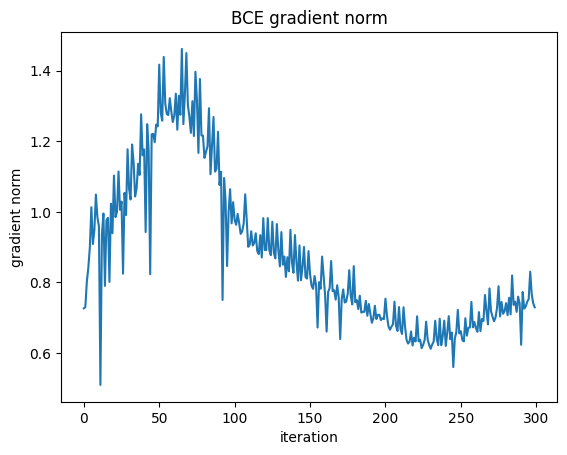

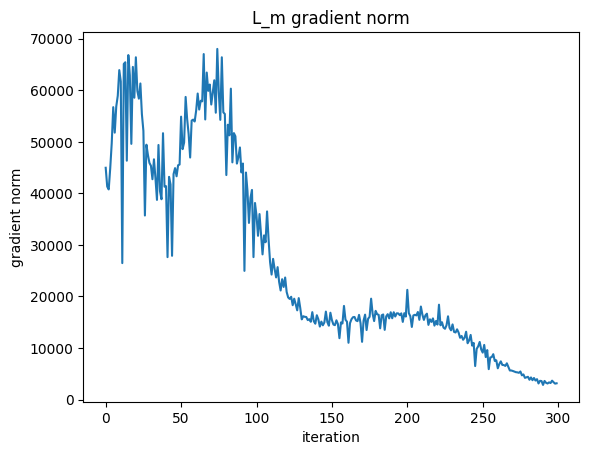

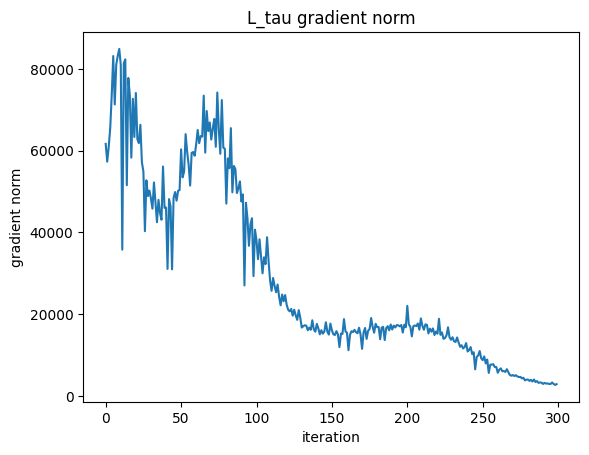

alpha : 5.655571031451277e-05 beta : 5.7358833293407646e-05


100%|██████████| 10000/10000 [09:31<00:00, 17.49it/s]


In [21]:
train_ratio = 0.9
noise_dim = 32
hidden_dim = 16
n_grad = 100
n_epochs = 10000
seed_value = 42
torch.manual_seed(seed_value)

gen, gen_opt, disc, disc_opt, target_train, target_test, condition_train, condition_test= VolGAN(
    log_return, implied_vol_surface_df, date_dt, train_ratio, noise_dim=noise_dim, hidden_dim=hidden_dim, n_epochs=n_epochs, n_grad=n_grad, batch_size=100)


In [26]:
N = 10000
m = np.linspace(0.6, 1.4, 10)
dte= [30, 60, 91, 122, 152, 182, 273, 365]
lk = 10
lt = 8
P_1, P_2, P_3 = penalty_tensor(m, dte) # shape: (8, 8), (10, 10), (10, 10)
m_tensor = torch.tensor(m_meshgrid, dtype=torch.float)
t_tensor = torch.tensor(tau_meshgrid, dtype=torch.float)
n_test = target_test.shape[0]  # number of test samples = 23 
total_pen_test = np.zeros((n_test, N))

P_1_test = P_1.expand(n_test, -1, -1)  # shape: (n_test, 8, 8)
P_2_test = P_2.expand(n_test, -1, -1)  # shape: (n_test, 10, 10)
P_3_test = P_3.expand(n_test, -1, -1)  # shape: (n_test, 10, 10)

ts_t_test = t_tensor.expand(n_test, -1, -1)
ms_t_test = m_tensor.expand(n_test, -1, -1)

gen.eval()
fk = torch.empty(size=(N, n_test, lk, lt)) 
fk_surface = np.zeros((N, n_test, lk * lt))
fk_increment = np.zeros((N, n_test, lk * lt))
ret_u = np.zeros((N, n_test))

with torch.no_grad():
    for l in tqdm(range(N)):
        #sample noise
        noise = torch.randn((n_test, noise_dim), dtype=torch.float)
        #sample from the generator
        fake = gen(noise, condition_test[:, :]) # shape: (n_test, 81)
        surface_past_test = condition_test[:, 3:] # input condition a_t = (r_t-1, r_t-2, vol_t-1, log(implied_vol_t-1))
        #simulated implied vol surfaces as vectors
        fake_surface = torch.exp(fake[:, 1:] + surface_past_test)
        #simulated surfaces as a matrices
        fk_surface[l, :, :] = fake_surface.cpu().detach().numpy()
        #simulated increments
        fk_increment[l, :, :] = fake[:, 1:].cpu().detach().numpy()
        #simulated returns
        ret_u[l, :] = fake[:, 0].cpu().detach().numpy()
        for i in range(lt):
            fk[l, :, :, i] = fake_surface[:, (i * lk):((i + 1) * lk)]

        #calculating arbitrage penalties
        P_2_test = P_2.expand(n_test, -1, -1)
        P_3_test = P_3.expand(n_test, -1, -1)

        relative_price = relative_call_price(ms_t_test[:, :, :].permute(0, 2, 1), ts_t_test[:, :, :].permute(0, 2, 1), fk[l, :, :, :],0)

        _, _, _, total_pen = calculate_arbitrage_penalties(relative_price, P_1.unsqueeze(0).repeat((n_test, 1, 1)), P_2_test[:, :, :], P_3_test[:, :, :])
        total_pen_test[:, l] = total_pen.detach().numpy()

print("Arbitrage penalties using VolGAN loss:", "Mean = ", np.mean(total_pen_test), "| Std = ", np.std(total_pen_test), "| Median = ", np.median(total_pen_test))

100%|██████████| 10000/10000 [00:08<00:00, 1221.42it/s]

Arbitrage penalties using VolGAN loss: Mean =  0.5074275320204416 | Std =  0.3864245721212791 | Median =  0.7012284994125366


100%|██████████| 23/23 [00:00<00:00, 4229.24it/s]


Average mean before reweighting: 0.507428 | After reweighting: 0.31149957975745357
Std of means before reweighting: 0.386424 | After reweighting: 0.3553234010558619
Average median before reweighting: 0.701226 | Median of means after reweighting: 4.895005550811602e-05


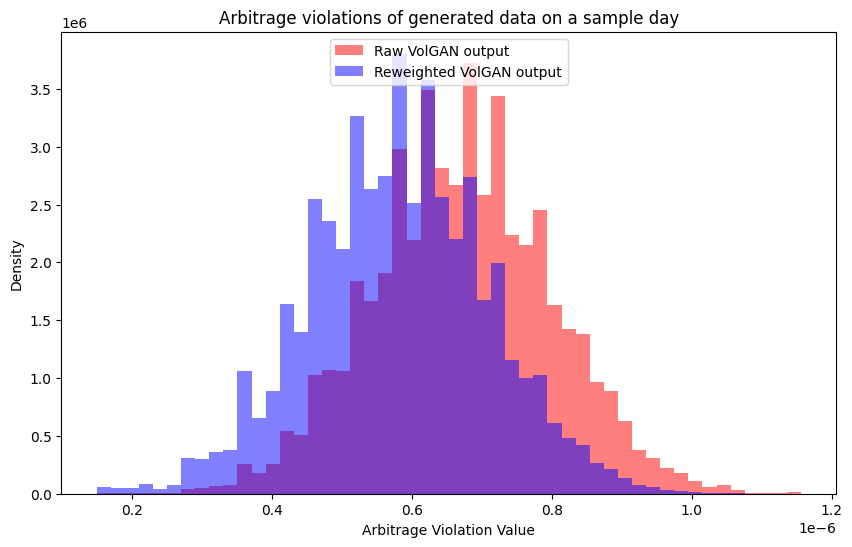

In [45]:
def reweight(phi_values, beta):
    # Apply exponential transformation to the penalties
    exp_reweights = np.exp(-beta * phi_values)

    # Normalize the transformed weights
    for i in range(exp_reweights.shape[0]):
        row_sum = np.sum(exp_reweights[i, :])
        if row_sum != 0:
            exp_reweights[i, :] /= row_sum
        else:
            exp_reweights[i, :] = 0

    # Calculate the mean and median penalty before reweighting
    mean_before = np.mean(phi_values, axis=1)
    median_before = np.median(phi_values, axis=1)

    # Initialize arrays to hold the mean and median after reweighting
    mean_after = np.zeros(exp_reweights.shape[0])
    median_after = np.zeros(exp_reweights.shape[0])

    # Calculate the mean and median after reweighting

    for i in tqdm(range(exp_reweights.shape[0])):
        # Calculate the weighted mean
        mean_after[i] = np.sum(exp_reweights[i, :] * phi_values[i, :])
    
        # Sort phi_values by the associated weights
        sorted_indices = np.argsort(phi_values[i])
        phi_values_sorted = phi_values[i, sorted_indices]
        cum_weights_sorted = np.cumsum(exp_reweights[i, sorted_indices])
    
        # Calculate the total weight
        total_weight = cum_weights_sorted[-1]
    
        # Find the index where the cumulative weight exceeds half the total weight
        median_index = np.searchsorted(cum_weights_sorted, total_weight / 2.0)
        median_value = phi_values_sorted[median_index]
    
        # Assign the median value
        median_after[i] = median_value
        

    return phi_values, exp_reweights, mean_before, median_before, mean_after, median_after


Phi, exp_reweights, mean_before, median_before, mean_after, median_after = reweight(total_pen_test, 1000)


def print_statistics(mean_before, mean_after):
    print(f"Average mean before reweighting: {np.mean(mean_before):.6f} | After reweighting: {np.mean(mean_after):}")
    print(f"Std of means before reweighting: {np.std(mean_before):.6f} | After reweighting: {np.std(mean_after):}")
    print(f"Average median before reweighting: {np.median(mean_before):.6f} | Median of means after reweighting: {np.median(mean_after):}")


print_statistics(mean_before, mean_after)


plt.figure(figsize=(10, 6)) 
plt.hist(Phi[20, :], bins=50, density=True, color='red', alpha=0.5, label='Raw VolGAN output')
plt.hist(Phi[20, :], bins=50, density=True, weights=exp_reweights[1, :], color='blue', alpha=0.5, label='Reweighted VolGAN output')
plt.legend(loc='upper center')
plt.title("Arbitrage violations of generated data on a sample day")
plt.xlabel("Arbitrage Violation Value")
plt.ylabel("Density")
plt.savefig("arbitrage_violations.png")
plt.show()

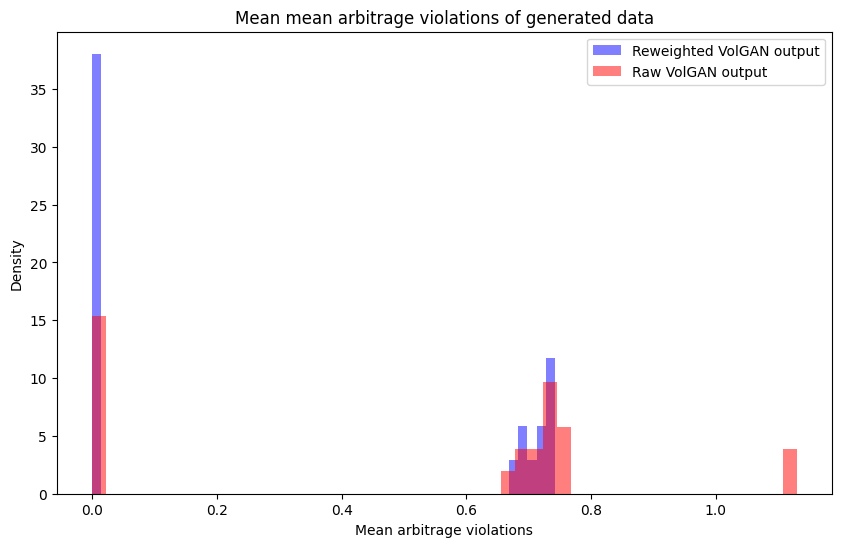

In [46]:
plt.figure(figsize=(10, 6))  
plt.hist(mean_after, bins=50, density=True, color='blue', alpha=0.5, label='Reweighted VolGAN output')
plt.hist(mean_before, bins=50, density=True, color='red', alpha=0.5, label='Raw VolGAN output')

plt.xlabel('Mean arbitrage violations')
plt.ylabel('Density')
plt.legend(loc='upper right') 
plt.title("Mean mean arbitrage violations of generated data")
plt.savefig("mean_arbitrage_violations.png")
plt.show()


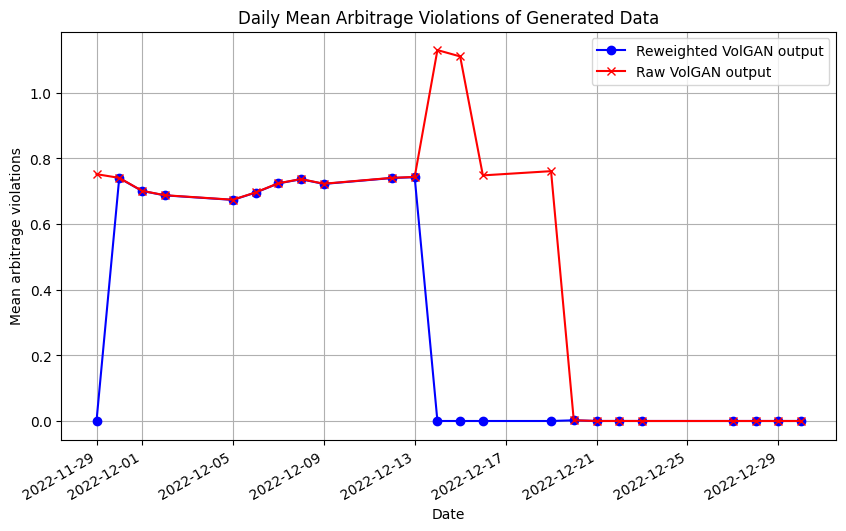

In [56]:
# test date
dates = dates_dt_new[-n_test:]
plt.figure(figsize=(10, 6))

plt.plot(dates, mean_after, marker='o', color='blue', label='Reweighted VolGAN output')
plt.plot(dates, mean_before, marker='x', color='red', label='Raw VolGAN output')
plt.xlabel('Date')
plt.ylabel('Mean arbitrage violations')
plt.legend(loc='upper right')
plt.title("Daily Mean Arbitrage Violations of Generated Data")
plt.grid(True)  
plt.gcf().autofmt_xdate()  
plt.savefig("daily_mean_arbitrage_violations_line_chart_with_dates.png")
plt.show()



### References
1. Milenavuletic. (n.d.). GitHub - milenavuletic/VolGAN: Code to accompany the paper “VolGAN: a generative model for arbitrage-free implied volatility surfaces.” GitHub. https://github.com/milenavuletic/VolGAN